In [8]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np


In [2]:
# simplified 1 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.ry(params[0], 0)

# 1 qubit parametrized state of one parameter
theta = np.pi/8 #generate a random target state; this is the goal we want to obtain
tgt_state = np.cos(theta/2) * Statevector.from_label('0') + np.sin(theta/2) * Statevector.from_label('1')

#params = np.array([[theta]])
params = np.array([[np.random.rand()*np.pi] for i in range(2)]) # for only one parameter in the circuit, over a few batches



"""___________________________________________________________________________________________________________"""
#full 2 qubit circuit
def apply_parametrized_gate_2(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.u(params[0], params[1],params[2], 0)
    qc.u(params[3], params[4],params[5], 1)
    qc.cx(0,1)


no_qubits = 2
tgt_state_2 = random_statevector(2**no_qubits)  



"""___________________________________________________________________________________________________________"""
def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

In [ ]:
#create state
state_target = StateTarget(tgt_state)
params = np.array([np.random.rand()*2* np.pi for n in range(6)])  #just to define the shape of params
backend_config = QiskitConfig(apply_parametrized_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low= 0, high = 2 * np.pi, shape=(1,)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 25, n_shots=1, seed=42),
    reward = reward_name[-1],   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)

In [ ]:
#create state
state_target = StateTarget(tgt_state_2)
params = np.array([np.random.rand()*2* np.pi for n in range(6)])  #just to define the shape of params
backend_config = QiskitConfig(apply_parametrized_gate_2)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 1000, n_shots=1, seed=42),  #use dfe_... for partition failure rate
    reward = reward_name[-1],   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


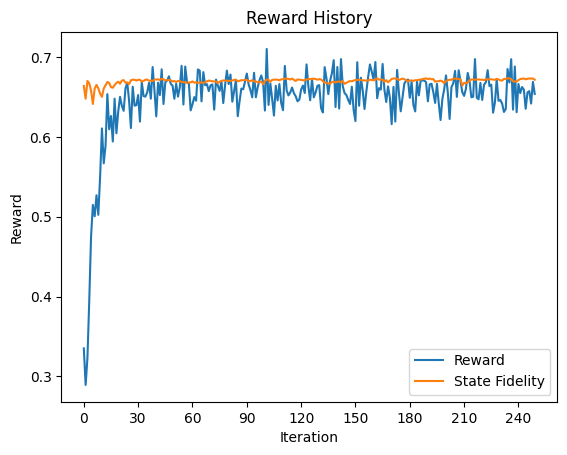

<Figure size 640x480 with 0 Axes>

In [5]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(100)
target_fidelity = 0.99
training_config = TrainingConfig(target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)


In [6]:
# compare number of shots needed for each reward
# compare the times it takes to converge?
# play with agent parameters
Qenv.total_shots[1]

np.int64(20000)

In [7]:
result.keys()

dict_keys(['avg_reward', 'fidelity_history', 'hardware_runtime', 'total_shots', 'total_updates', 'clipped_mean_action_0', 'mean_action_0', 'std_action_0', 'clipped_mean_action_1', 'mean_action_1', 'std_action_1', 'clipped_mean_action_2', 'mean_action_2', 'std_action_2', 'clipped_mean_action_3', 'mean_action_3', 'std_action_3', 'clipped_mean_action_4', 'mean_action_4', 'std_action_4', 'clipped_mean_action_5', 'mean_action_5', 'std_action_5', 'mean_action', 'std_action', 'clipped_mean_action'])

In [13]:
#gate target test 0

def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

"""_____________________________________________________________________________________________________________________________________________________________________________________________________"""


# simplified 1 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.ry(2*params[0], 0)

#create random 1 qubit gate and obtain its choi state
params = np.array([np.random.rand()*2* np.pi for i in range(1)])
qc = QuantumCircuit(1)
qc.ry(2*params[0], 0)

specific_gate = qc.to_gate(label="U_entangle")
gate_target = GateTarget(specific_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
backend_config = QiskitConfig(apply_parametrized_gate)

config = QEnvConfig(target = gate_target, 
                    backend_config=backend_config,
                    execution_config=ExecutionConfig(batch_size = 20, sampling_paulis = 25, n_shots=1, seed=42),
                    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
                    reward=reward_name[-1],
                    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)
Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)


# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(100)
target_fidelity = 0.99
training_config = TrainingConfig(target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(



 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.49436872251390684]
Finished simulation benchmark


AttributeError: 'GateTarget' object has no attribute 'dm'